In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')
print(os)

<module 'os' from '/Users/caslabs/opt/anaconda3/envs/musicautobot/lib/python3.10/os.py'>


In [3]:
from utils.musicautobot.numpy_encode import *
from utils.musicautobot.utils.file_processing import process_all, process_file
from utils.musicautobot.config import *
from utils.musicautobot.music_transformer import *

2023-04-25 02:46:49.707011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Generate Music with Pretrained Model

### Load Pretrained

In [12]:
# Location of your midi files
midi_path =  Path('/Users/caslabs/Documents/port/music-generation/data/input')

# Location of saved datset
data_path = Path('/Users/caslabs/Documents/port/music-generation/data/models')

In [13]:
# Data
data = MusicDataBunch.empty(data_path)
vocab = data.vocab

# For Saved Data:
#data = load_data(data_path, 'musicitem_data_save.pkl')

In [10]:
# Pretrained Model
# Download pretrained model if you haven't already
#pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformerKeyC.pth'
# pretrained_url = 'https://ashaw-midi-web-server.s3-us-west-2.amazonaws.com/pretrained/MusicTransformer.pth'

#pretrained_path = data_path/'pretrained'/Path(pretrained_url).name
#download_url(pretrained_url, dest=pretrained_path)

In [11]:
# Learner
learn = music_model_learner(data, pretrained_path="/Users/caslabs/Documents/port/music-generation/data/models/music_transformer.pth", config=default_config())

## Prediction

#### Choose existing midi file as a starting point

In [14]:
midi_files = get_files(midi_path, recurse=True, extensions='.midi');

[PosixPath('/Users/caslabs/Documents/port/music-generation/data/input/b.midi'),
 PosixPath('/Users/caslabs/Documents/port/music-generation/data/input/a.midi')]

In [15]:
idx = 1
f = midi_files[idx]; f

PosixPath('/Users/caslabs/Documents/port/music-generation/data/input/a.midi')

#### NextWord/Autocomplete

Trim the song to only a few notes. Model will use these notes a seed and continue the idea

In [16]:
cutoff_beat = 10

item = MusicItem.from_file(f, data.vocab)
seed_item = item.trim_to_beat(cutoff_beat)

/Users/caslabs/Documents/port/music-generation/utils/musicautobot/numpy_encode.py:53: StreamIteratorInefficientWarning: highestTime is not defined on StreamIterators. Call .stream() first for efficiency
  highest_time = max(s.flat.getElementsByClass('Note').highestTime, s.flat.getElementsByClass('Chord').highestTime)


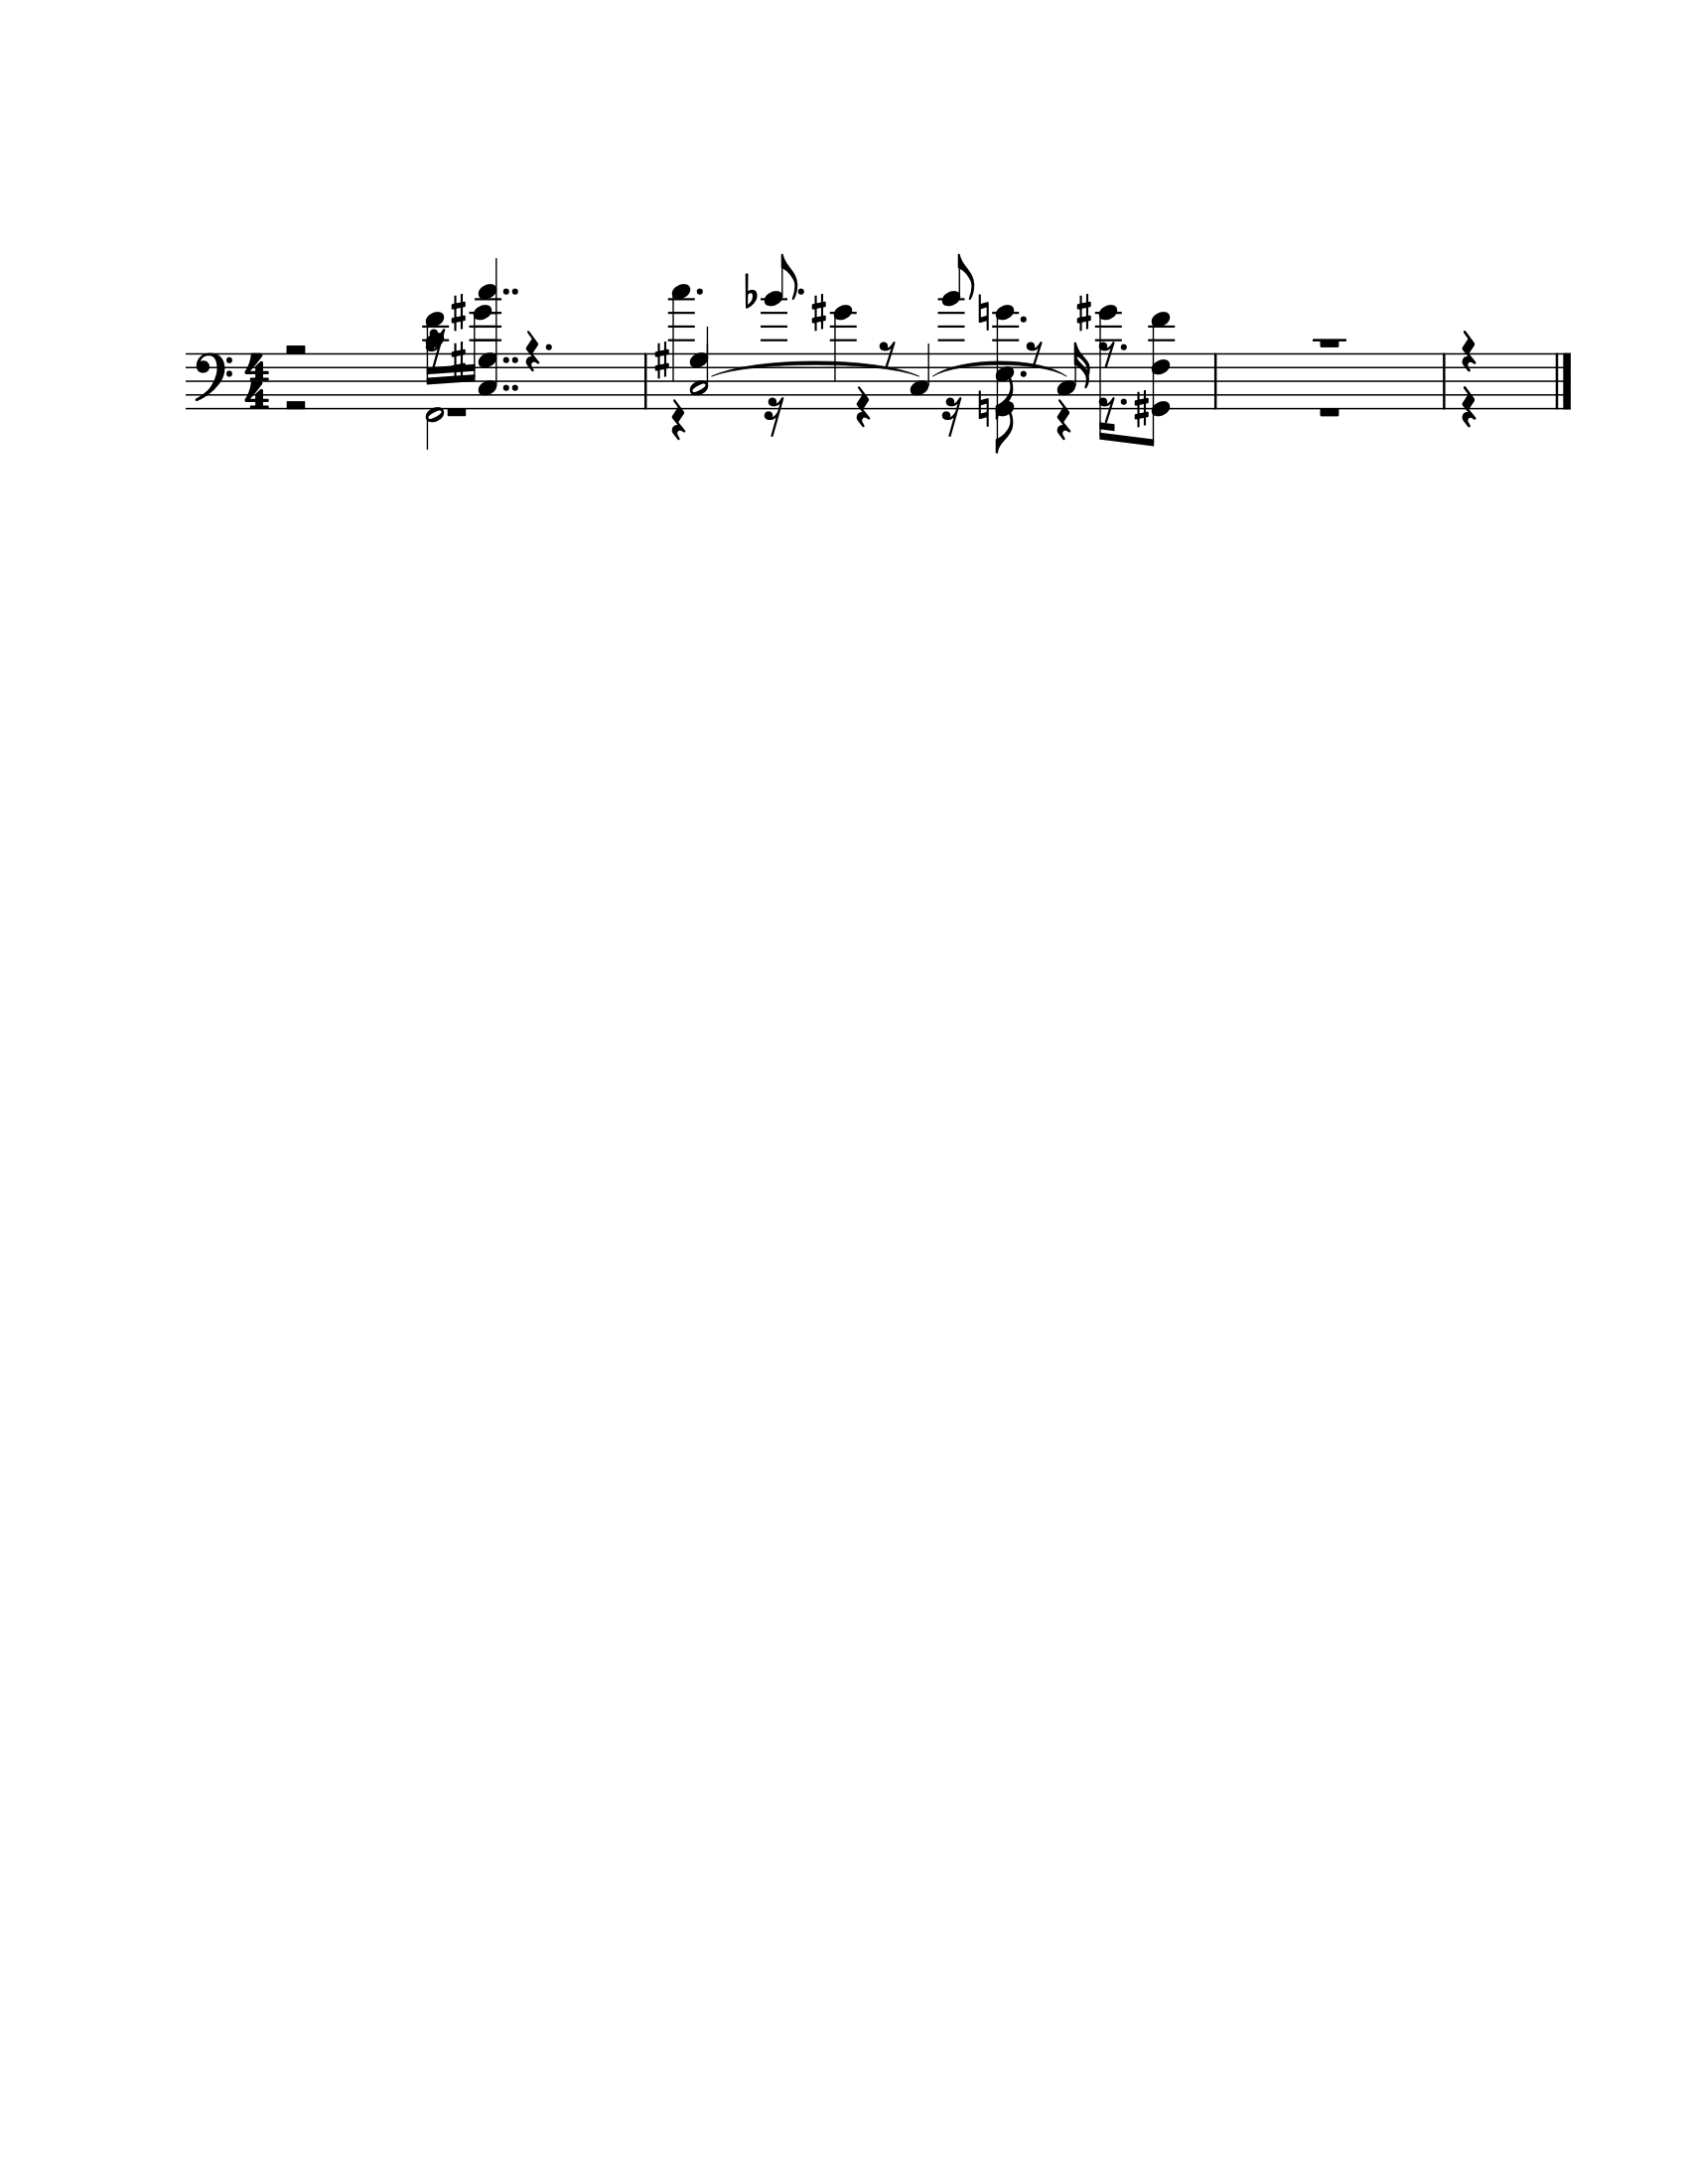

In [17]:
seed_item.show()

In [18]:
seed_item.play()
#seed_item.download(filename='audio/seed.mid', ext='mid')

#### Use seed to predict next sequence

In [19]:
pred, full = learn.predict(seed_item, n_words=400, temperatures=(1.1,0.4), min_bars=12, top_k=24, top_p=0.7)

Non midi note detected. Only returning valid portion. Index, seed 192 (200, 2)


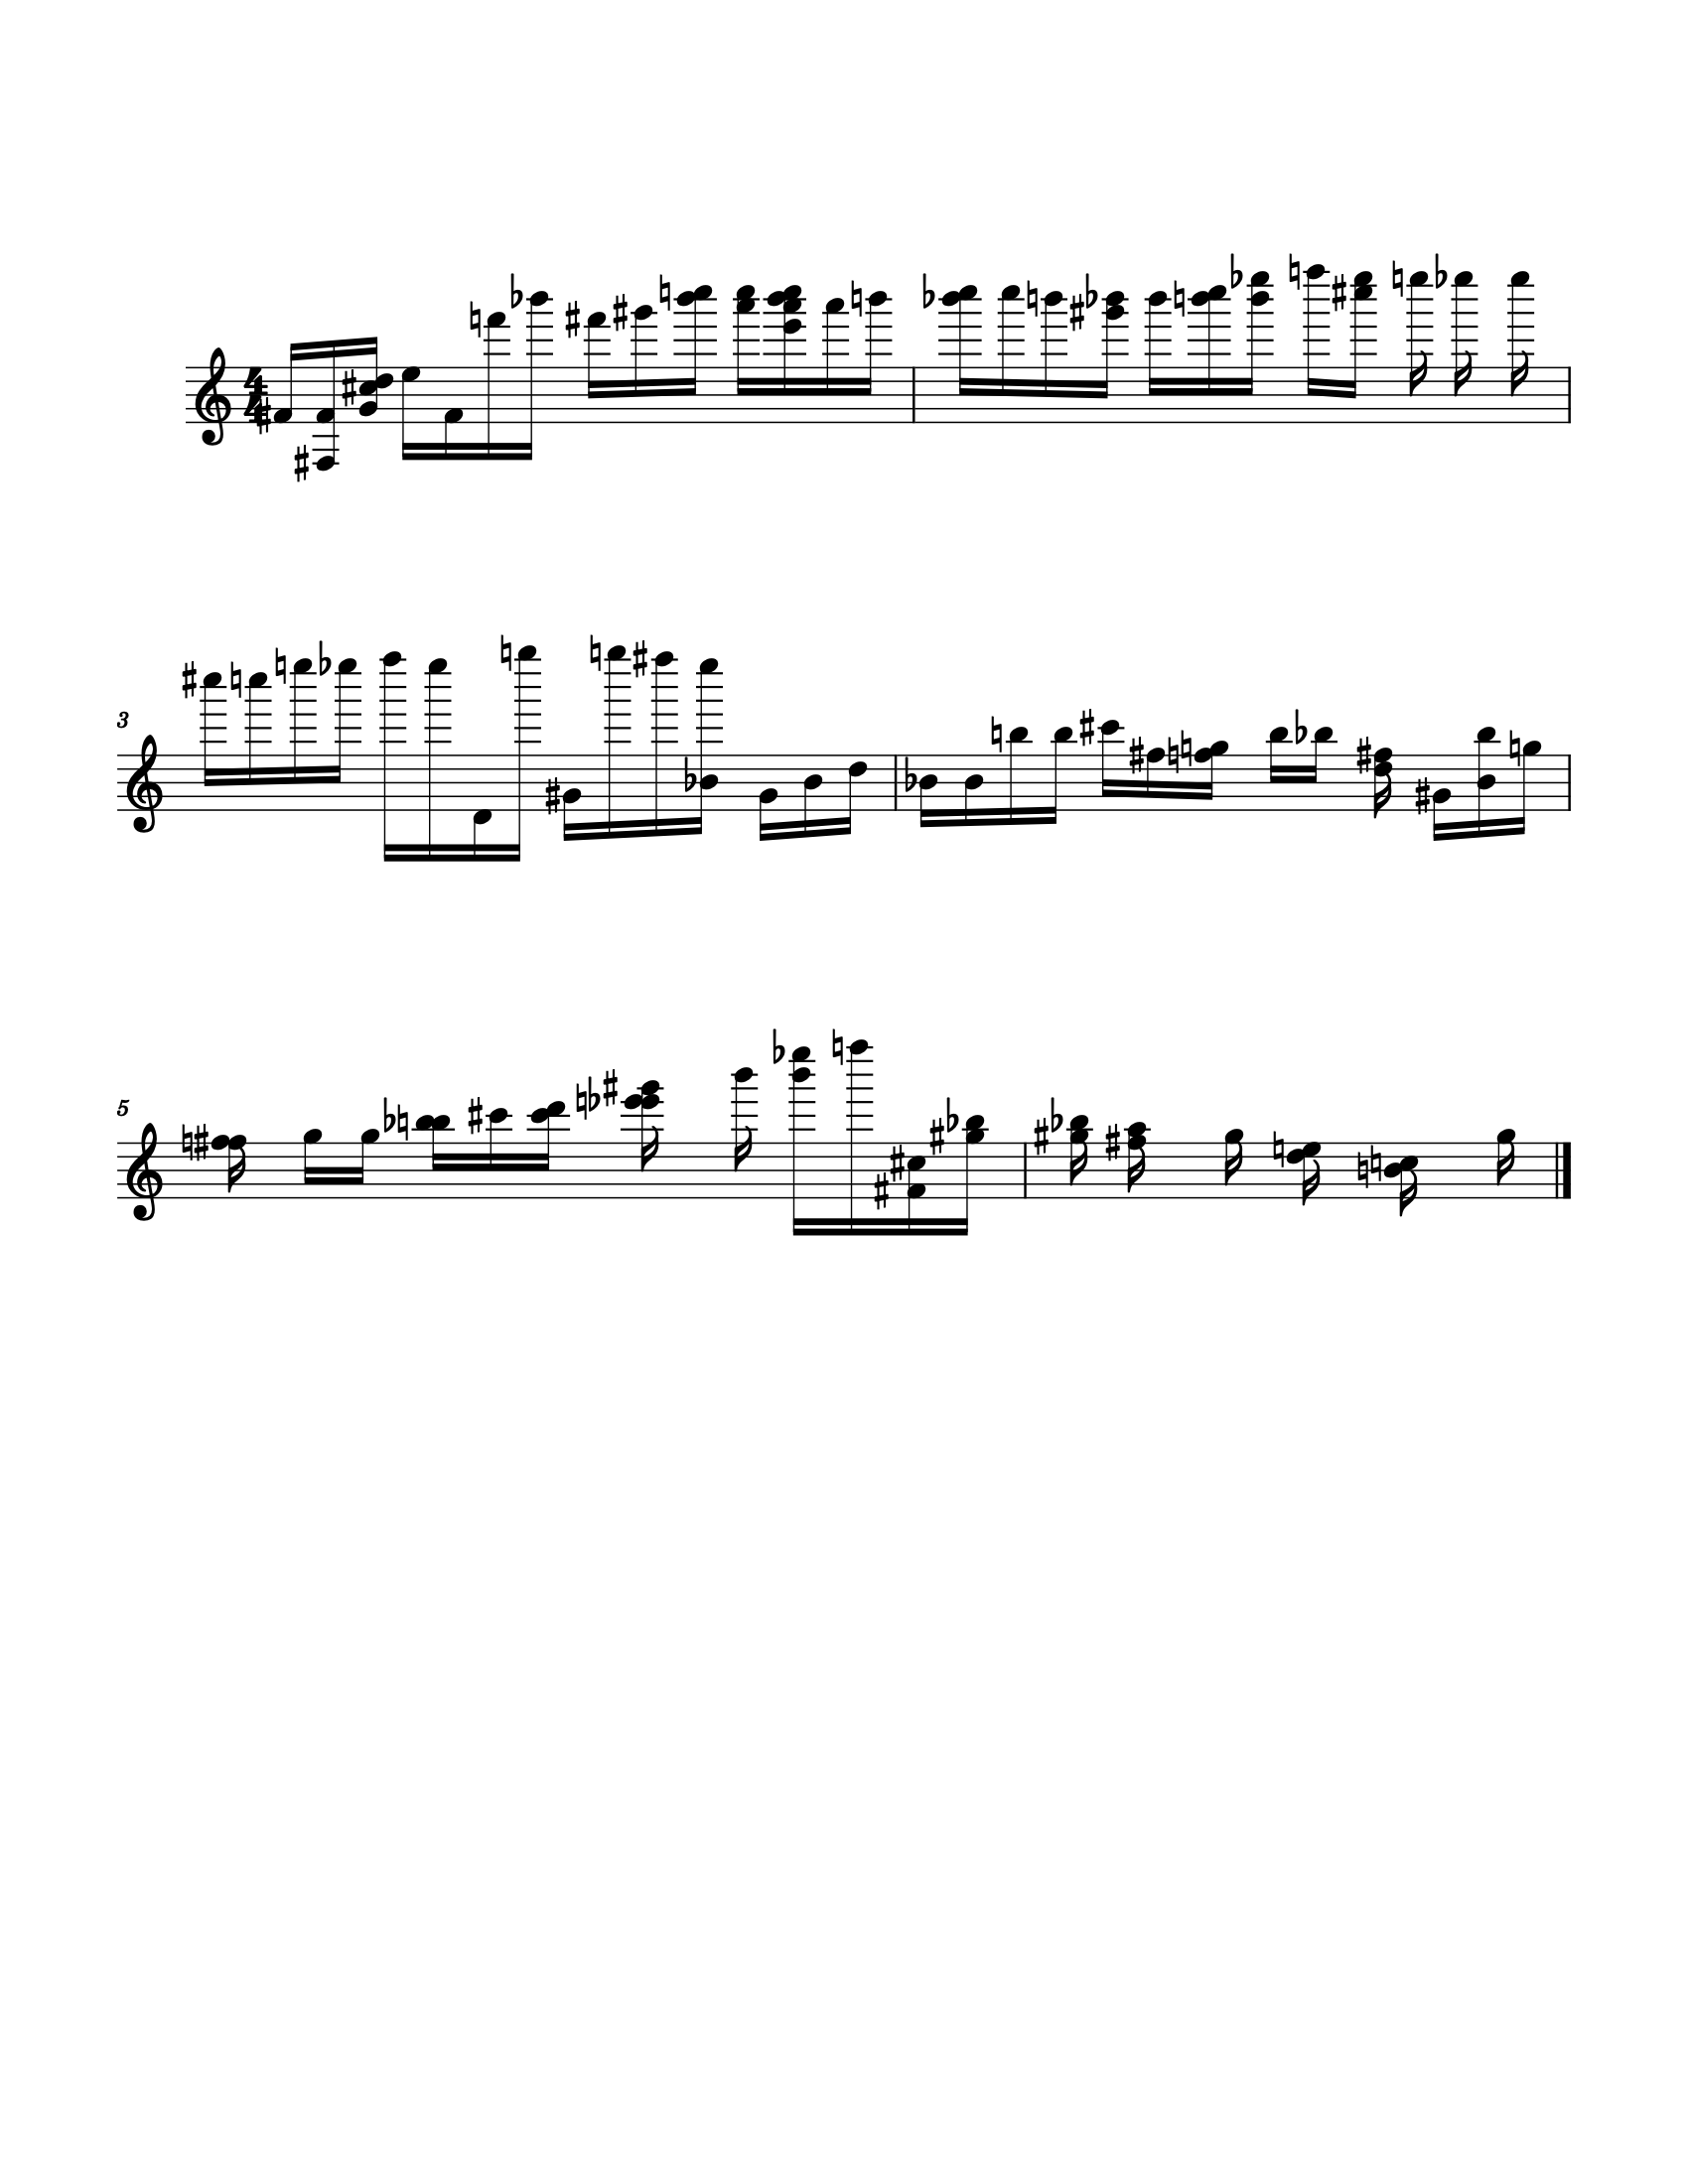

In [20]:
pred.show()

In [21]:
pred.play()

In [22]:
print(pred)


MusicItem - (400,)
xxsep d1 n66 d1 xxsep d1 n66 d1 n54 d1...


In [17]:
# write the stream to a MIDI file
pred.download(filename='audio/pred.mid', ext='mid')

'audio/pred.mid'

Non midi note detected. Only returning valid portion. Index, seed 222 (230, 2)


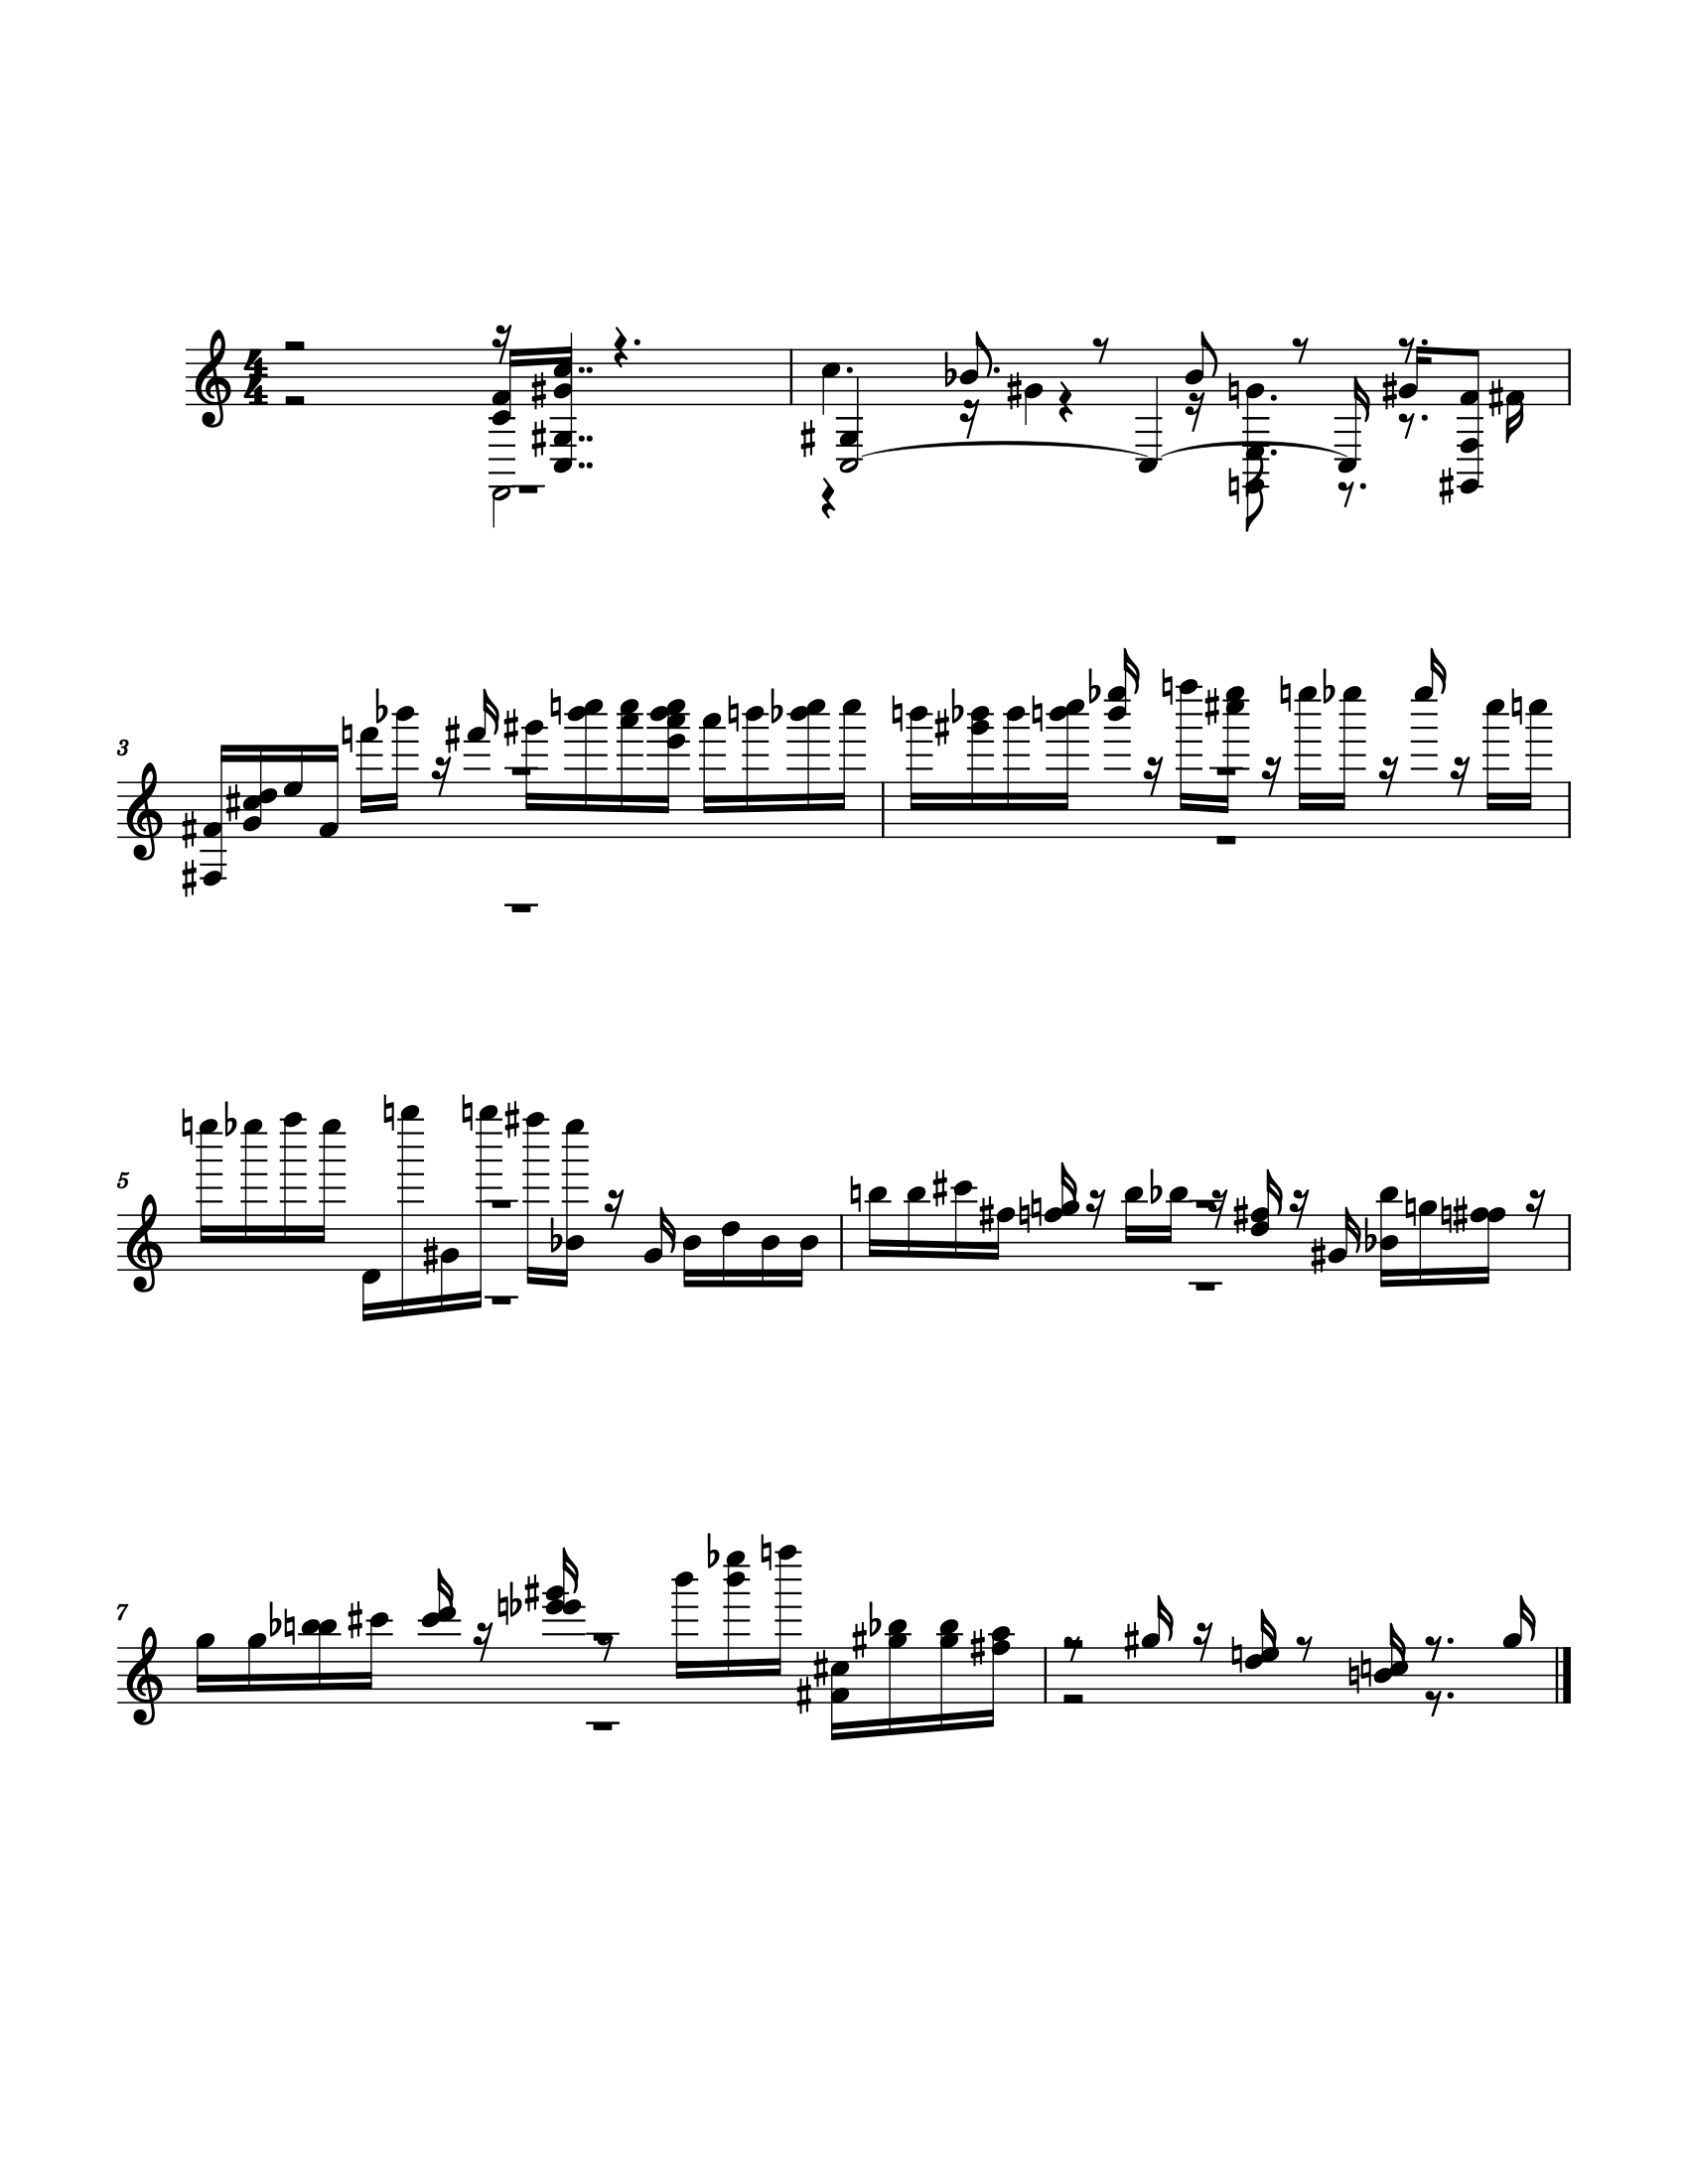

In [23]:
full_song = seed_item.append(pred); full_song.show()

In [24]:
full_song.play()

#### Add More Randomness to prediction

In [25]:
note_temp = 1.4 # Determines amount of variation in note pitches
dur_temp = 0.8 # Amount of randomness in rhythm
top_k = 30
pred, full = learn.predict(seed_item, n_words=400, temperatures=(note_temp, dur_temp), min_bars=12, top_k=top_k, top_p=0.7)

Non midi note detected. Only returning valid portion. Index, seed 14 (200, 2)


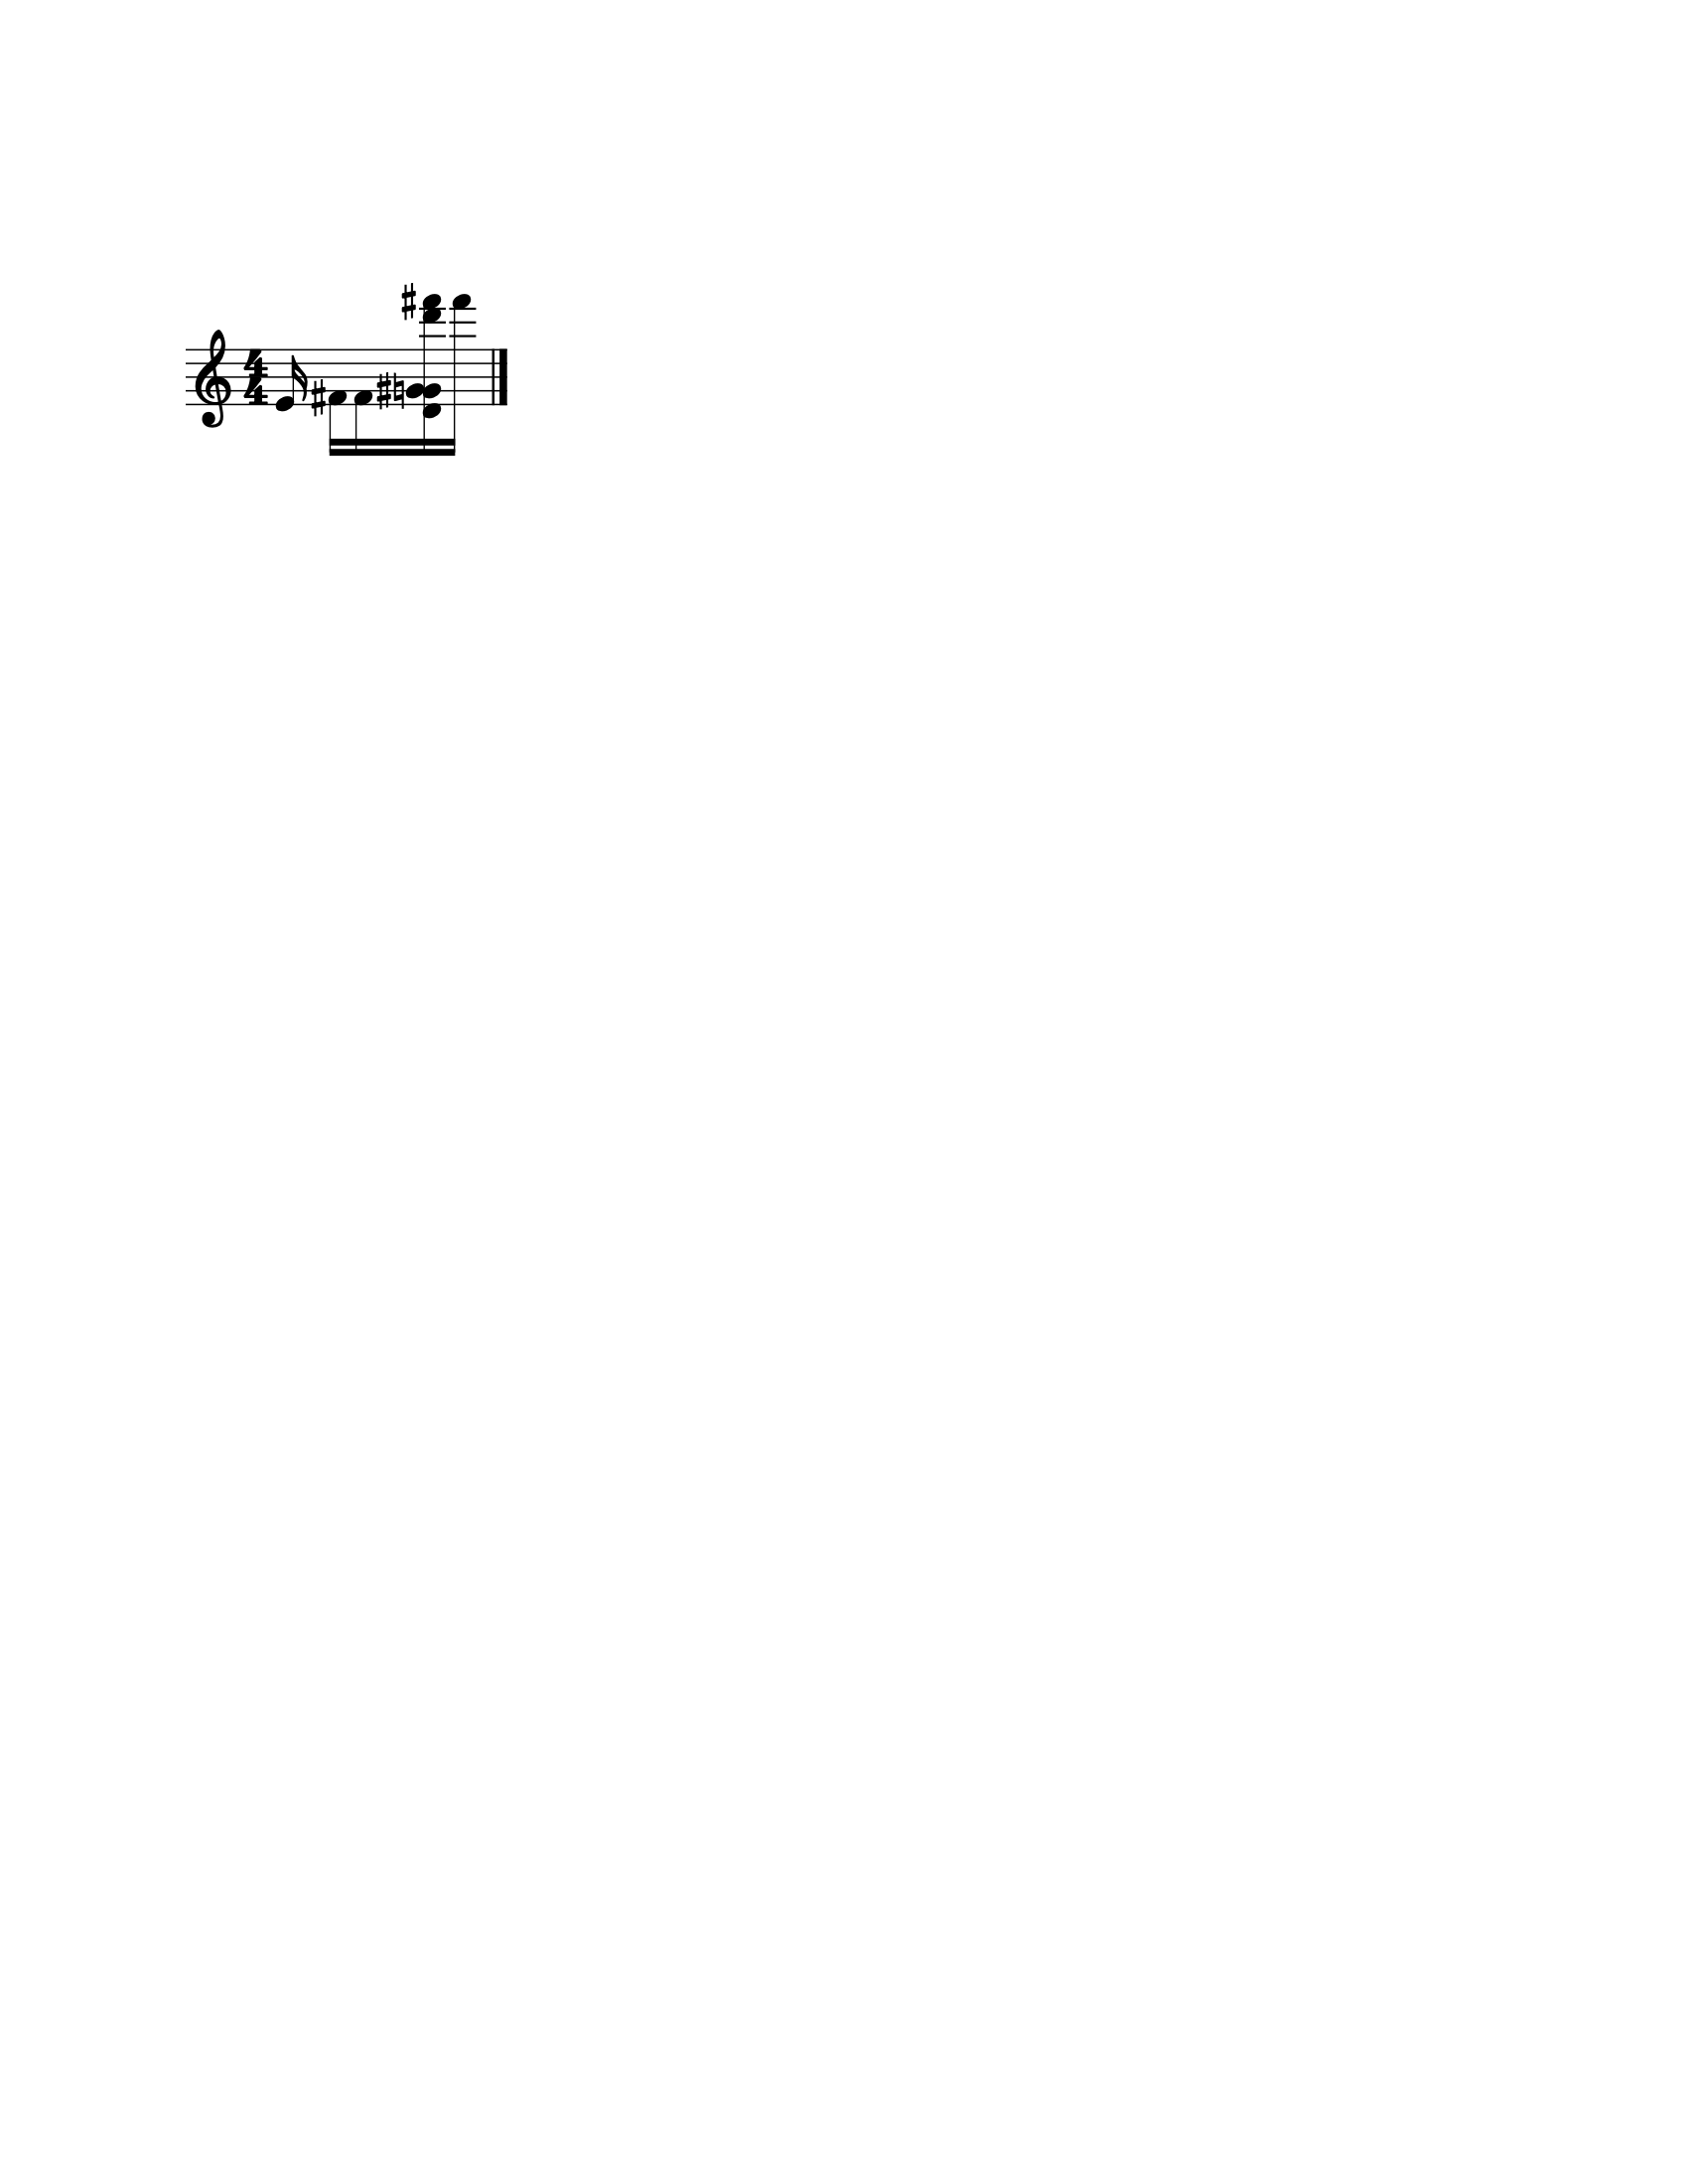

In [26]:
pred.show()

In [27]:
pred.play()

### Pop Music Theory

According to hooktheory, the most popular chord progression is I-V-vi-IV  
https://www.hooktheory.com/theorytab/common-chord-progressions

/Users/caslabs/Documents/labs/APPLYAI/explore/musicautobot/musicautobot/numpy_encode.py:53: StreamIteratorInefficientWarning: highestTime is not defined on StreamIterators. Call .stream() first for efficiency
  highest_time = max(s.flat.getElementsByClass('Note').highestTime, s.flat.getElementsByClass('Chord').highestTime)


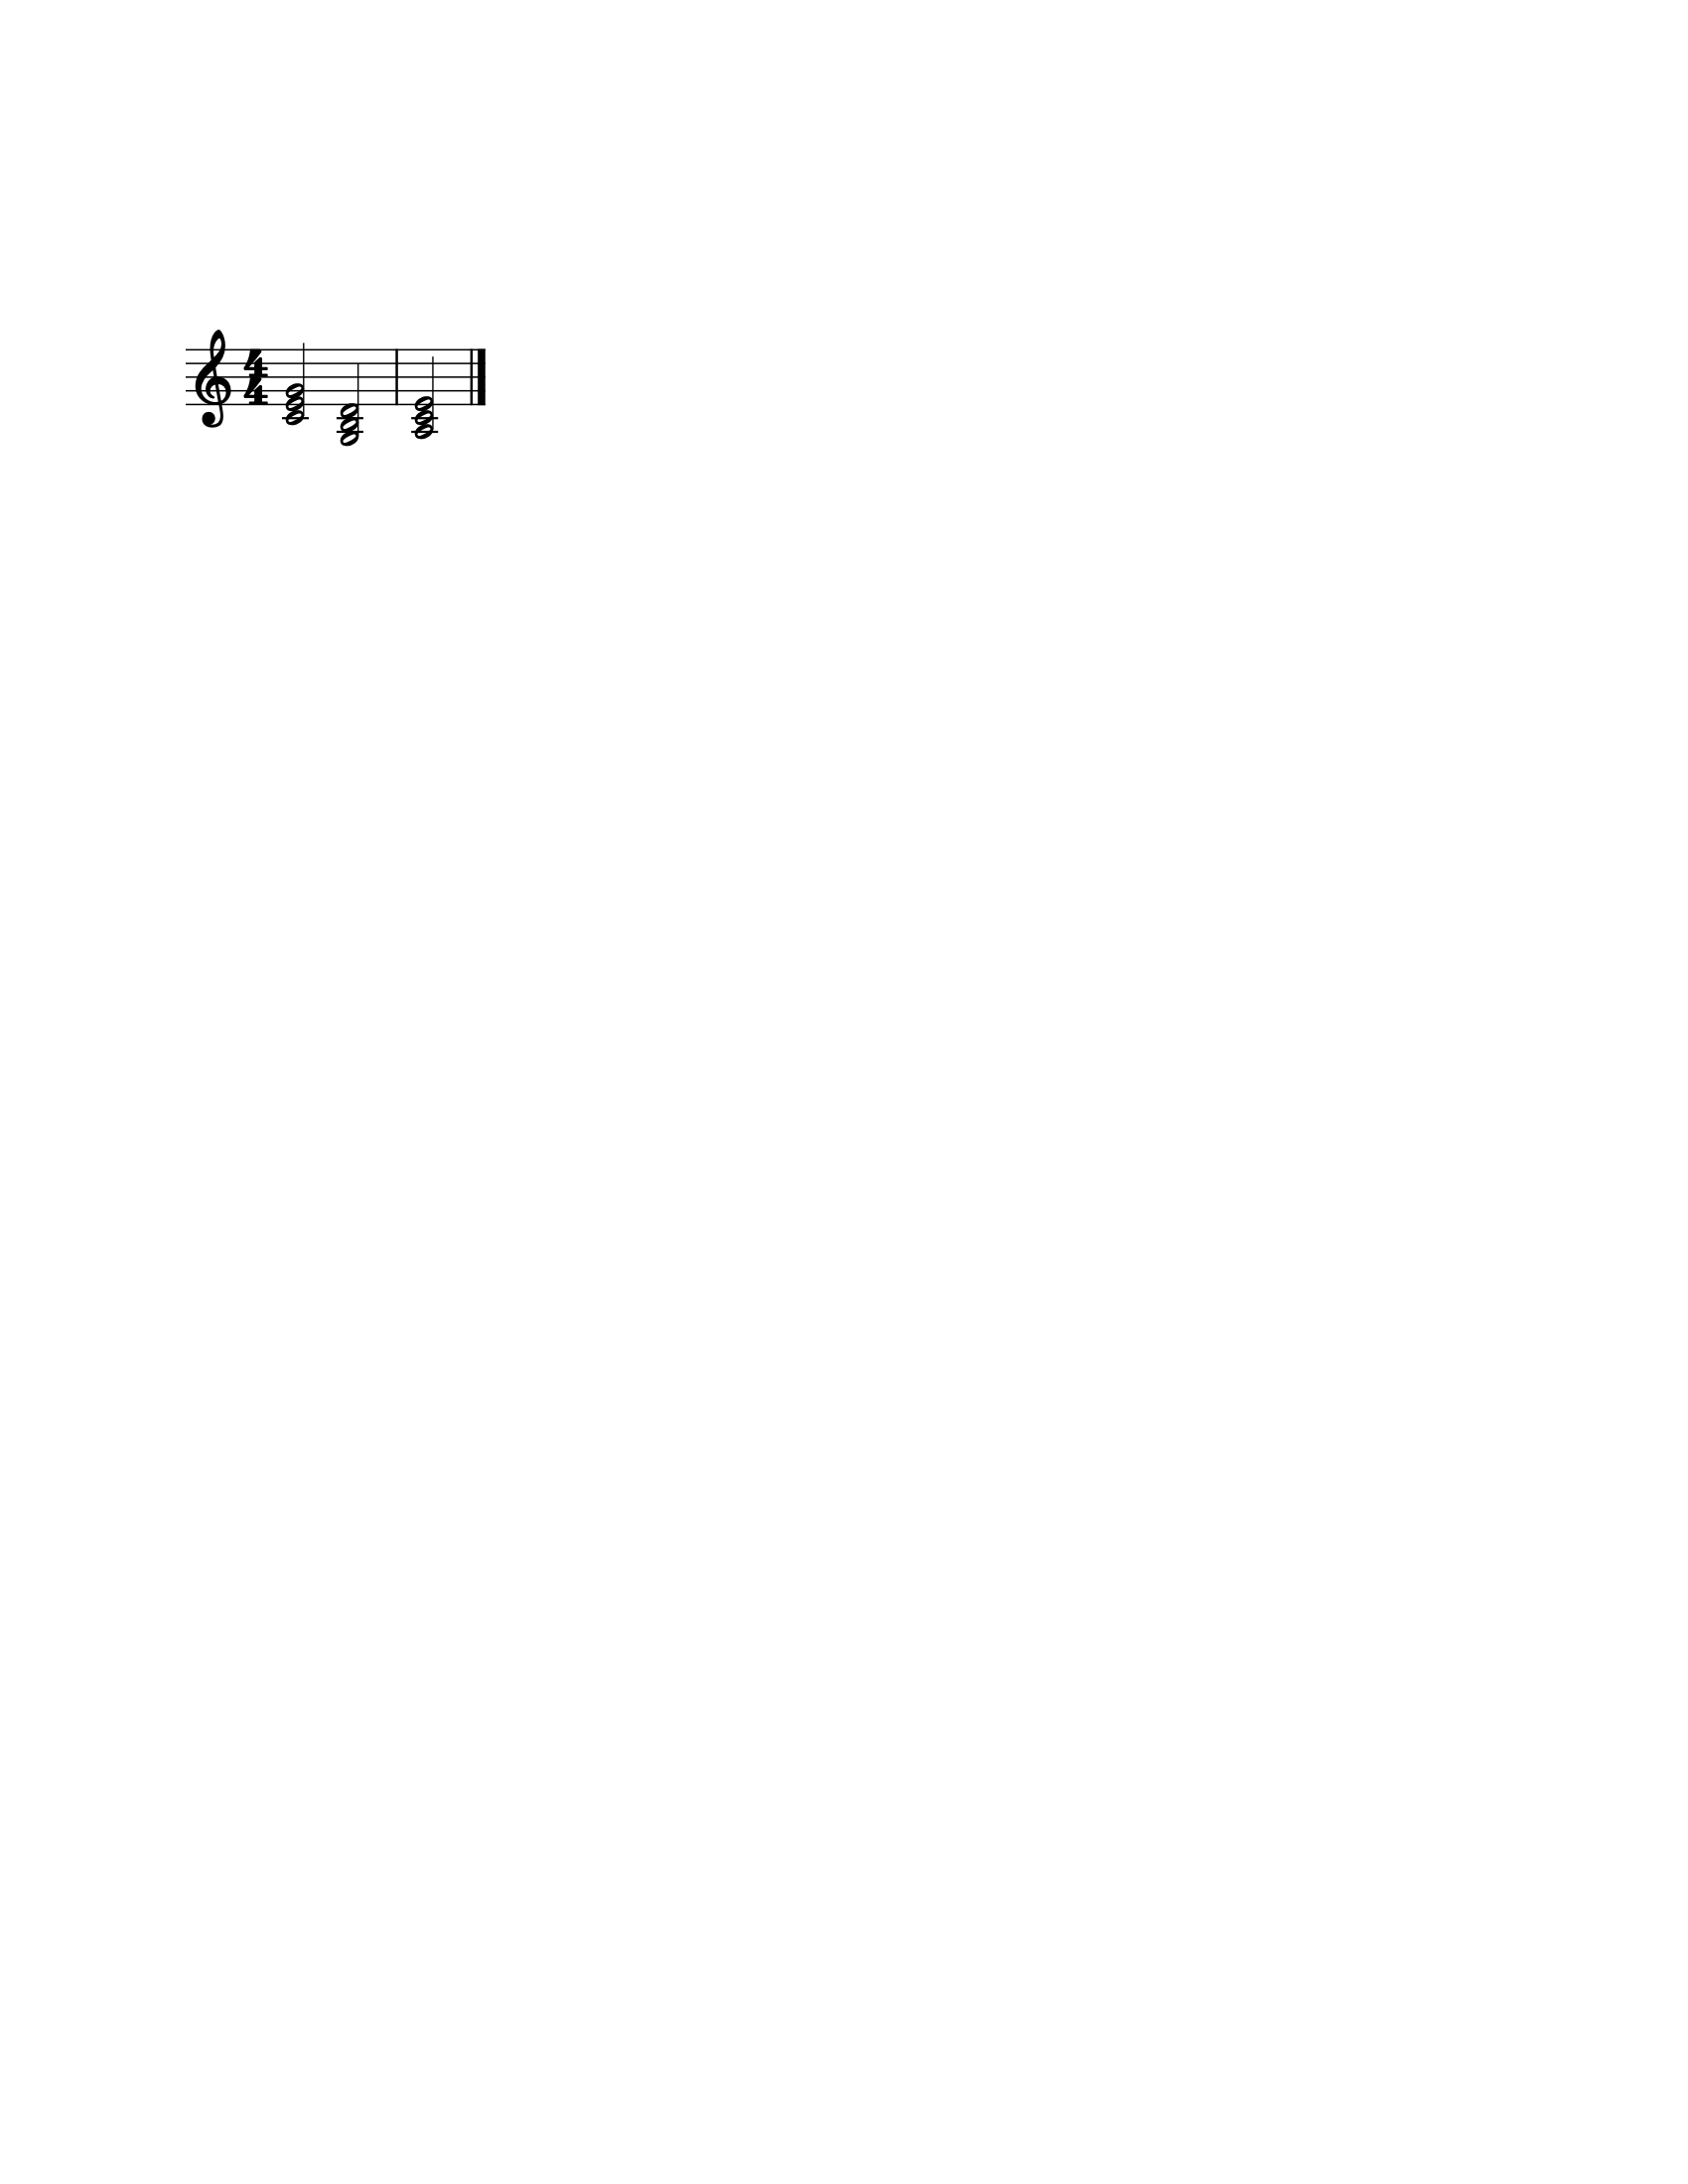

In [36]:
# Let's create a partial progression I-V-vi
p = music21.stream.Part()
p.append(music21.chord.Chord('C4 E4 G4', type='half')) # I
p.append(music21.chord.Chord('G3 B3 D4', type='half')) # V
p.append(music21.chord.Chord('A3 C4 E4', type='half')) # vi
s = music21.stream.Score([p])
chord_item = MusicItem.from_stream(s, vocab)
chord_item.show()

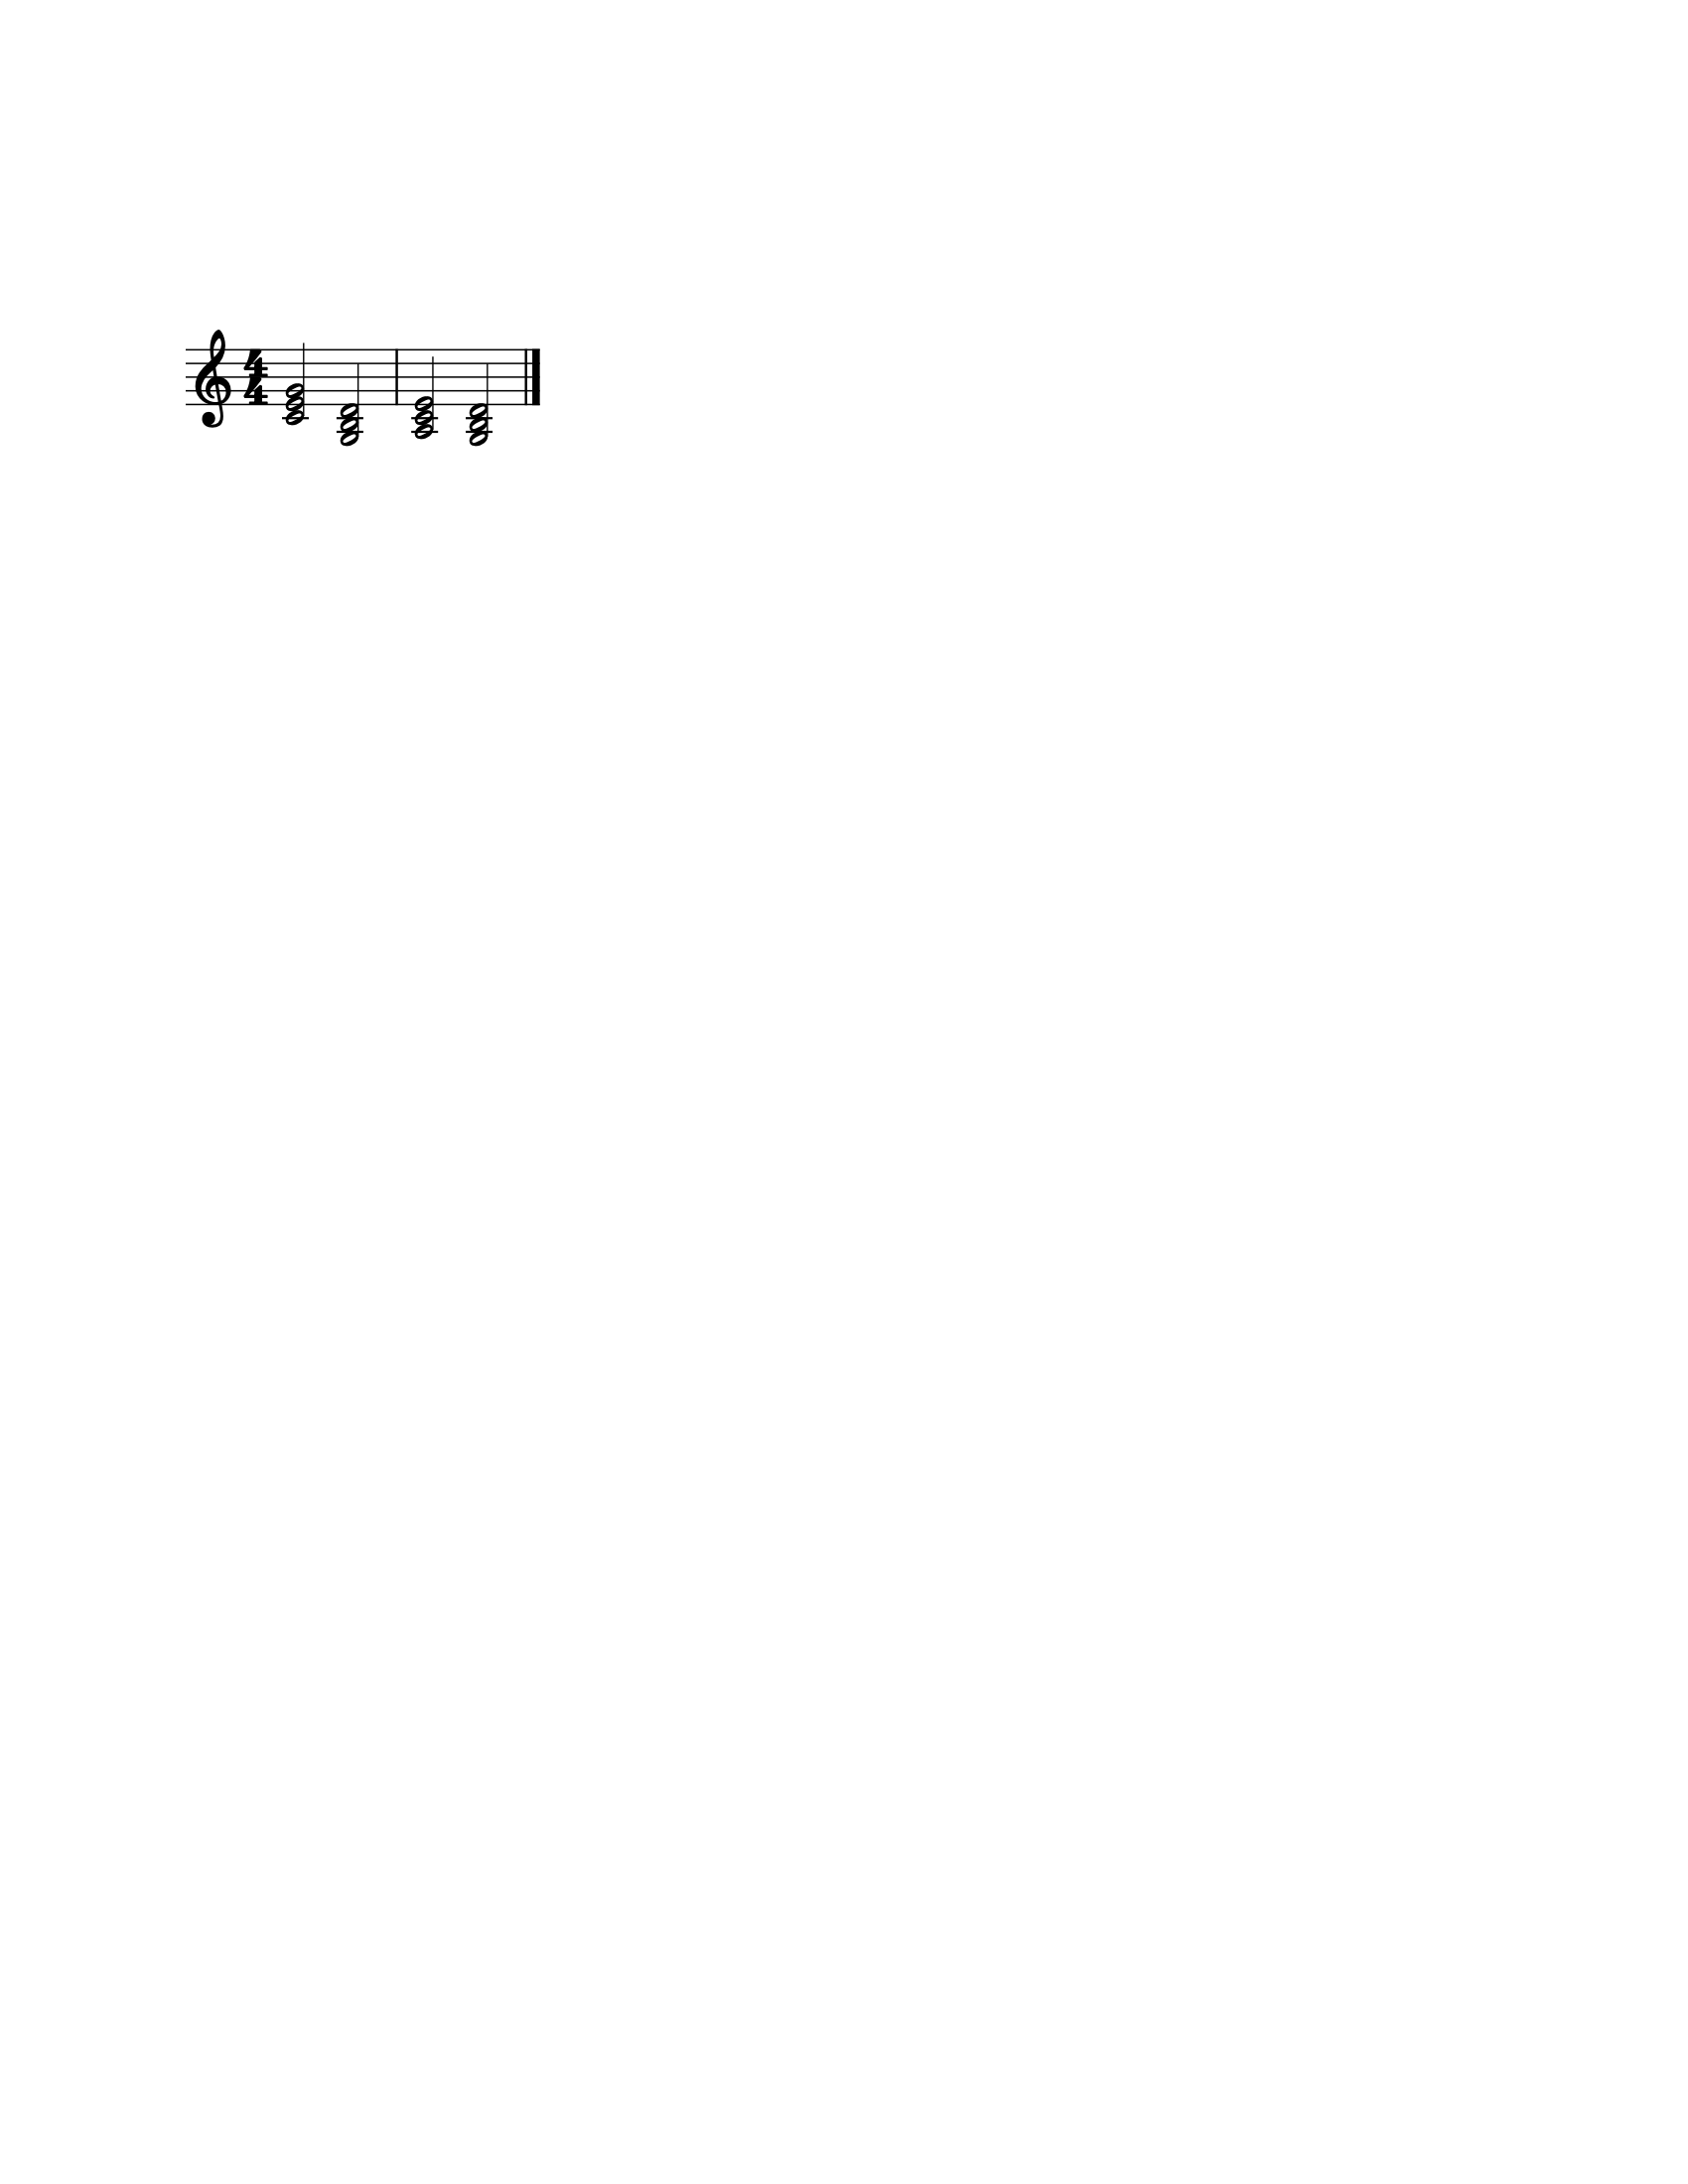

In [37]:
temperaturs = (0.5,0.5) # Let's lower the note randomness for this test
pred, full = learn.predict(chord_item, n_words=10, temperatures=(0.5,0.5))
full.show()

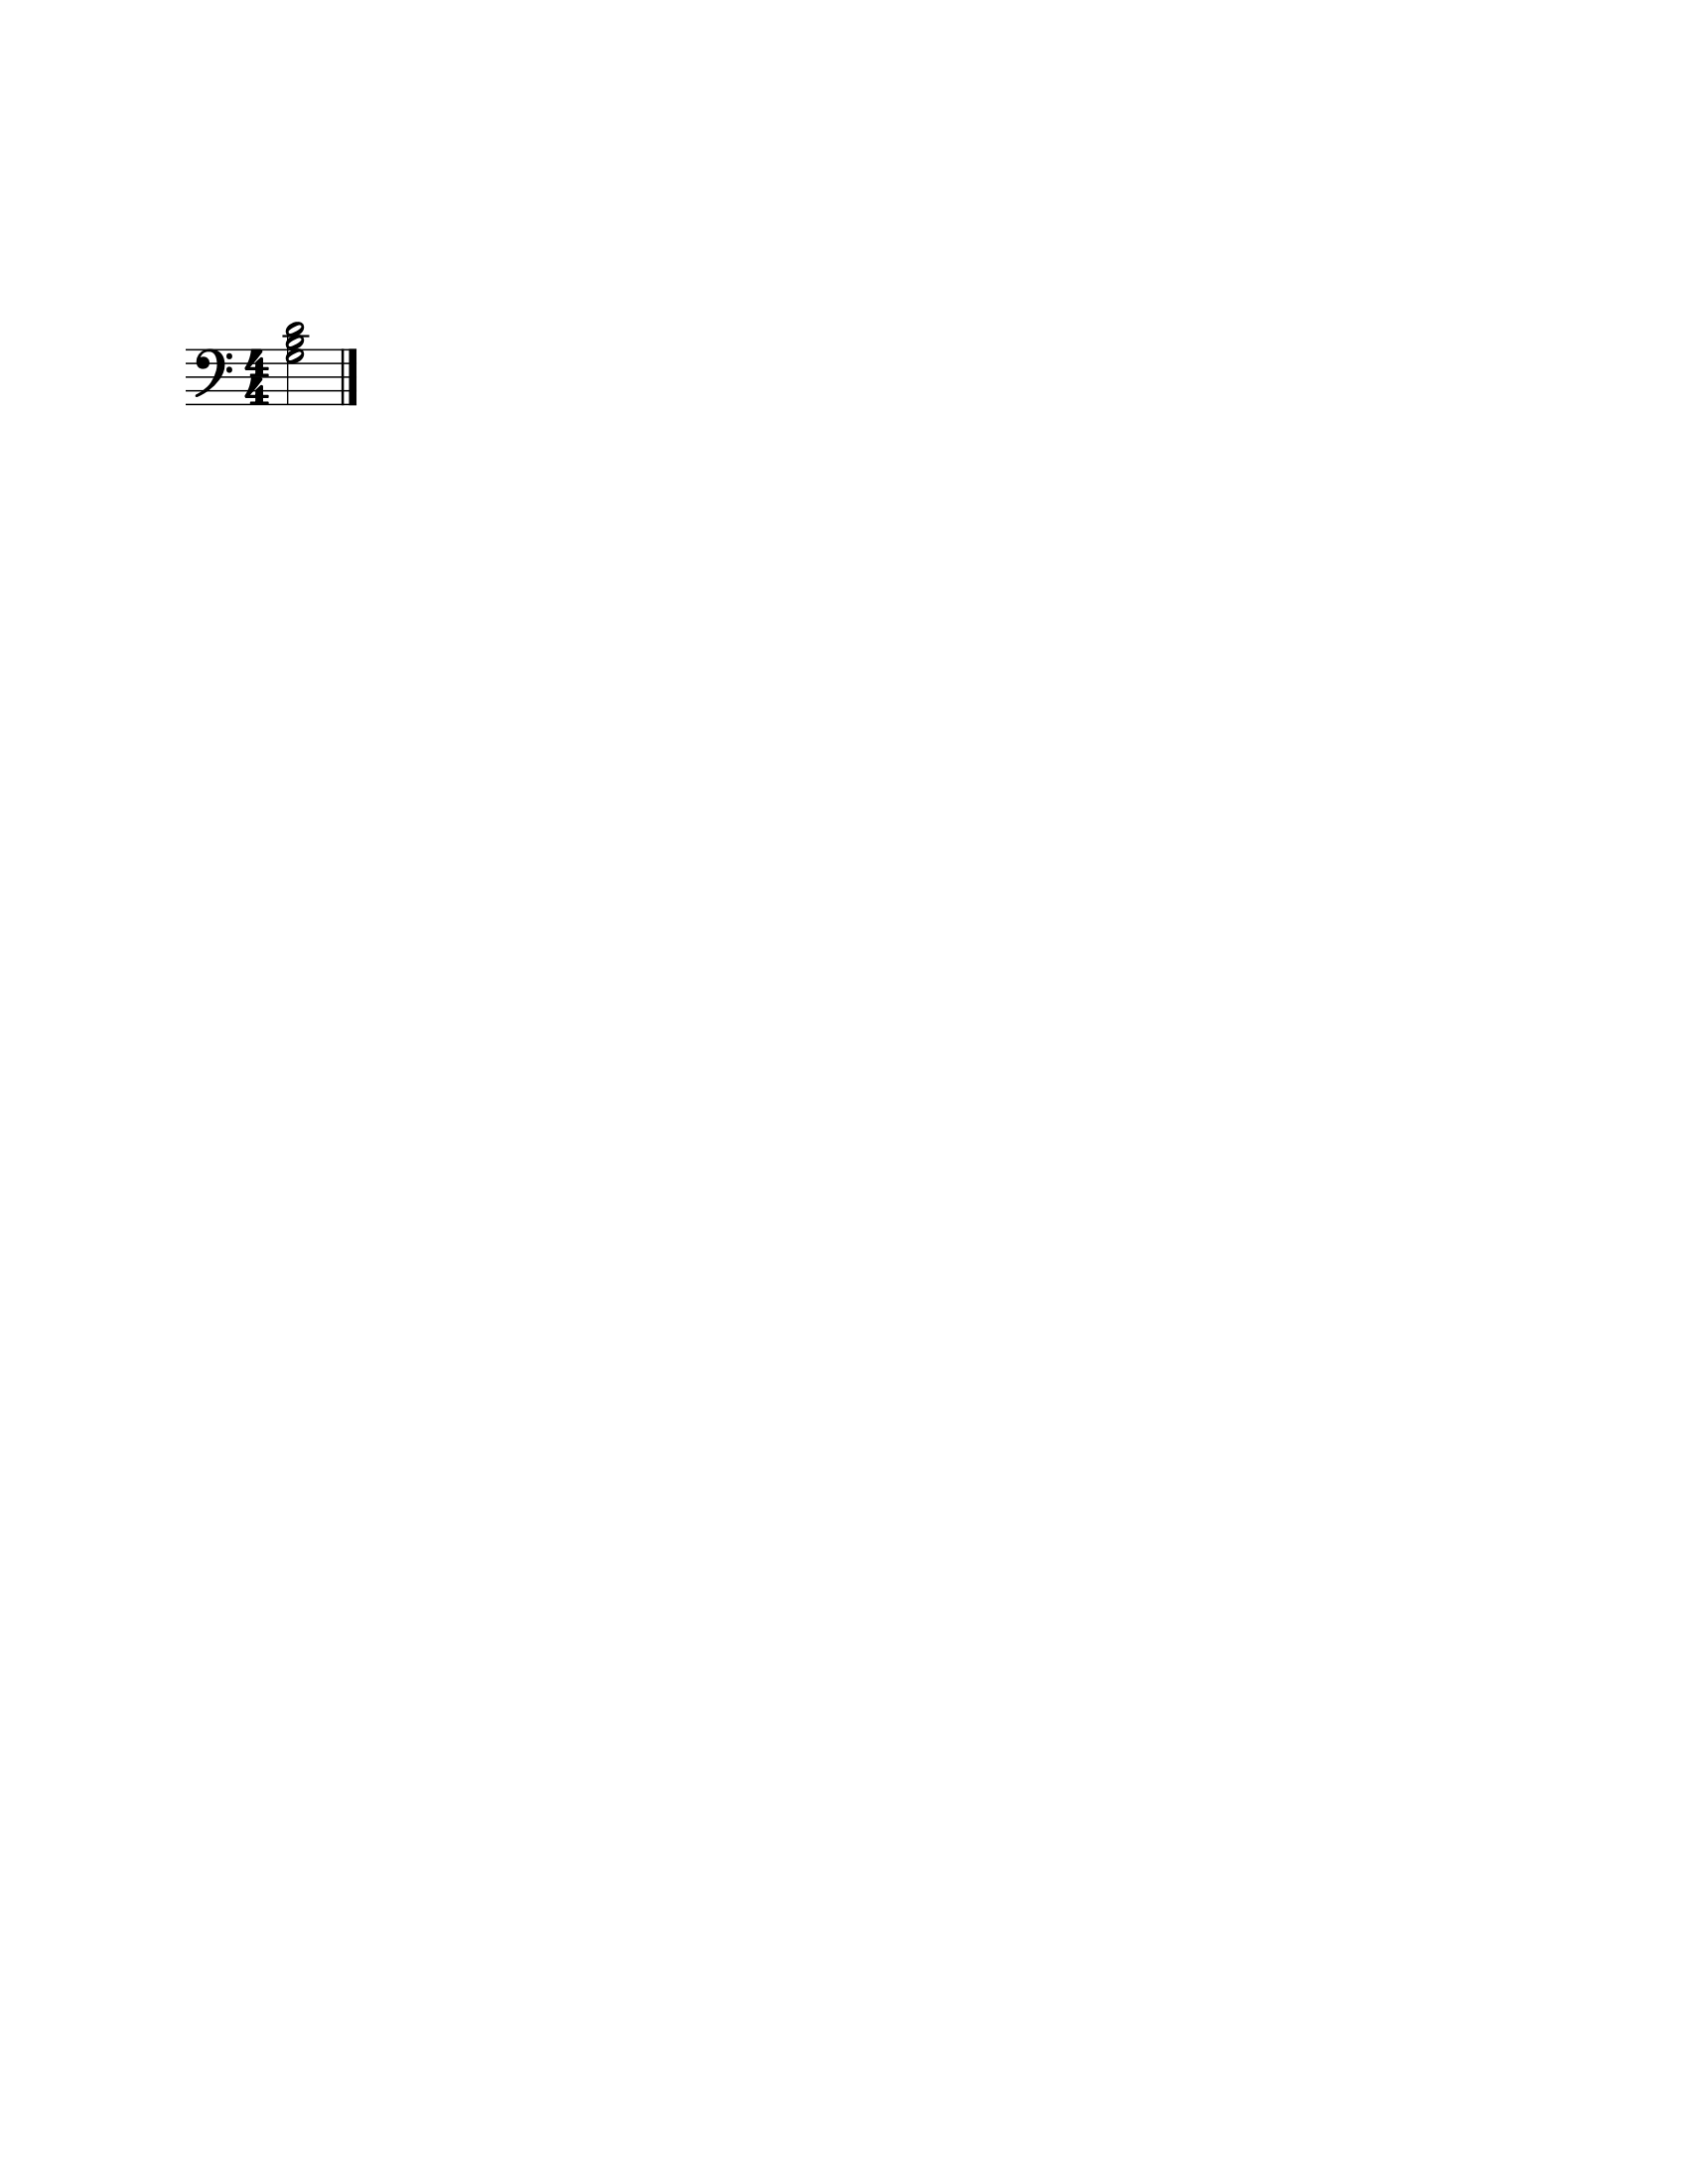

In [38]:
# Predicted chords - IV
pred.show()

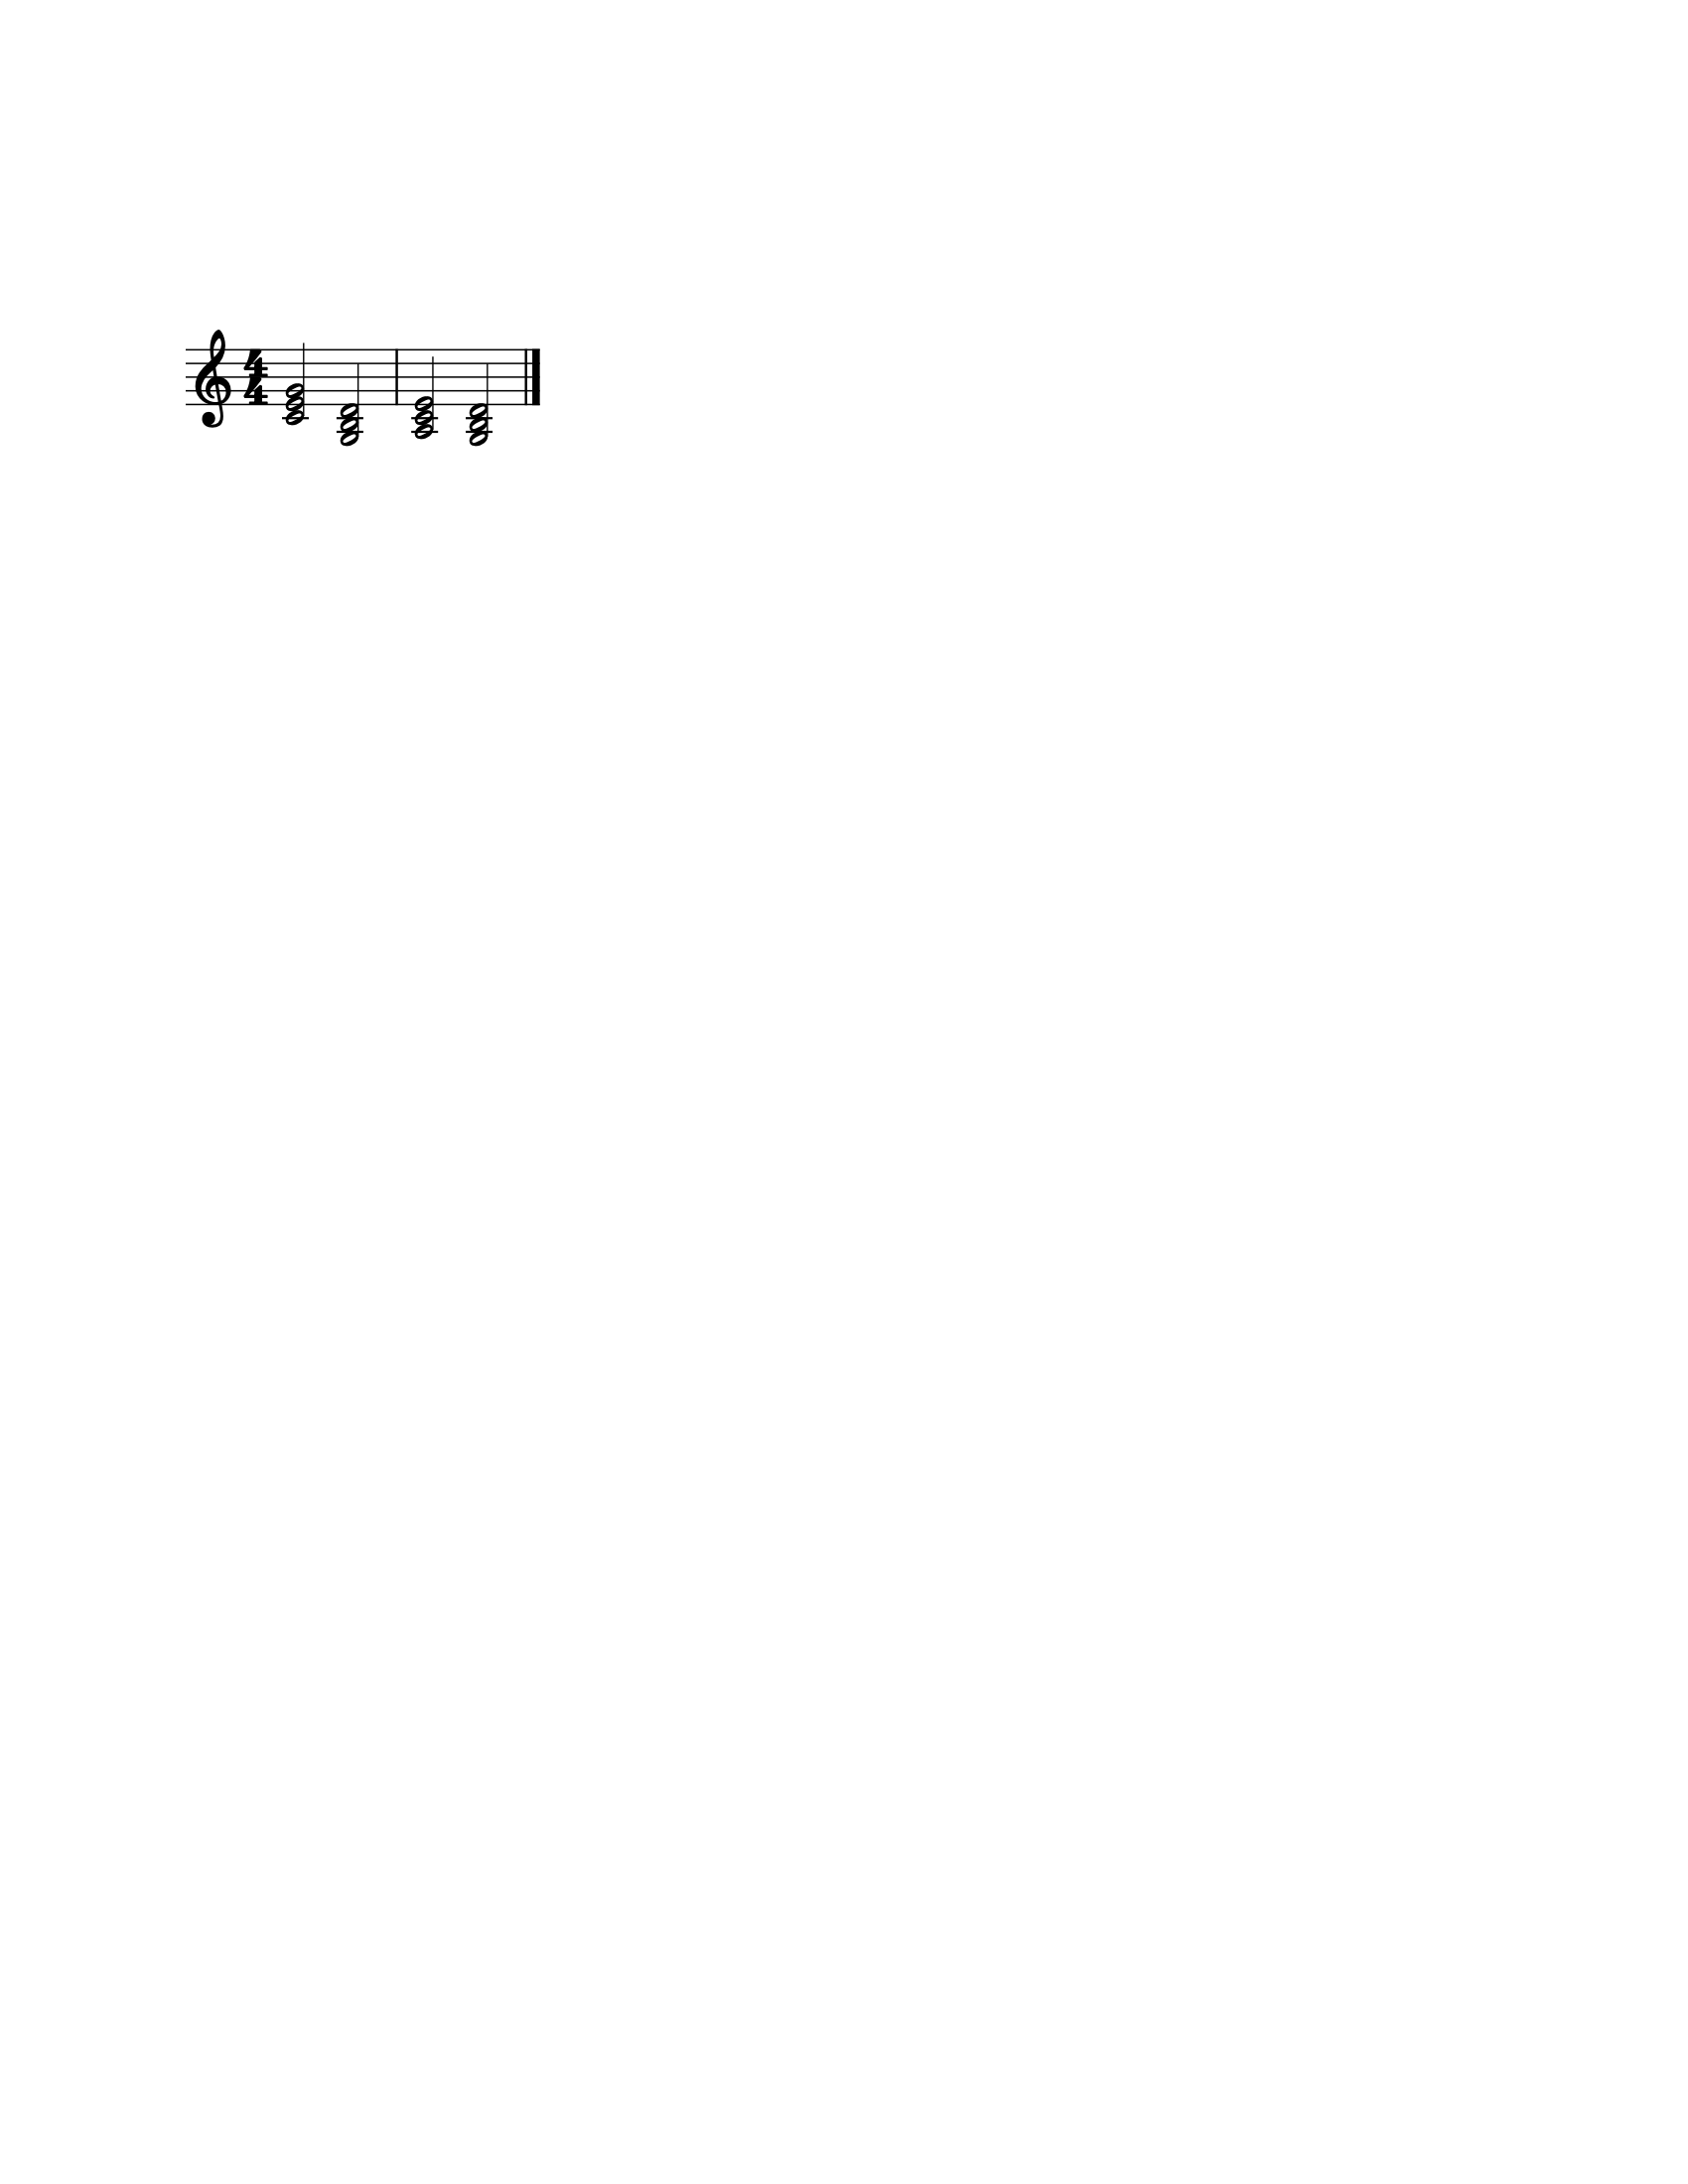

In [39]:
# Full sequence
chord_item.append(pred).show()

Looks like it predicted the most popular progression!

#### Predict without a starting sequence

In [40]:
empty_item = MusicItem.empty(vocab)

In [41]:
pred, full = learn.predict(empty_item, n_words=200)

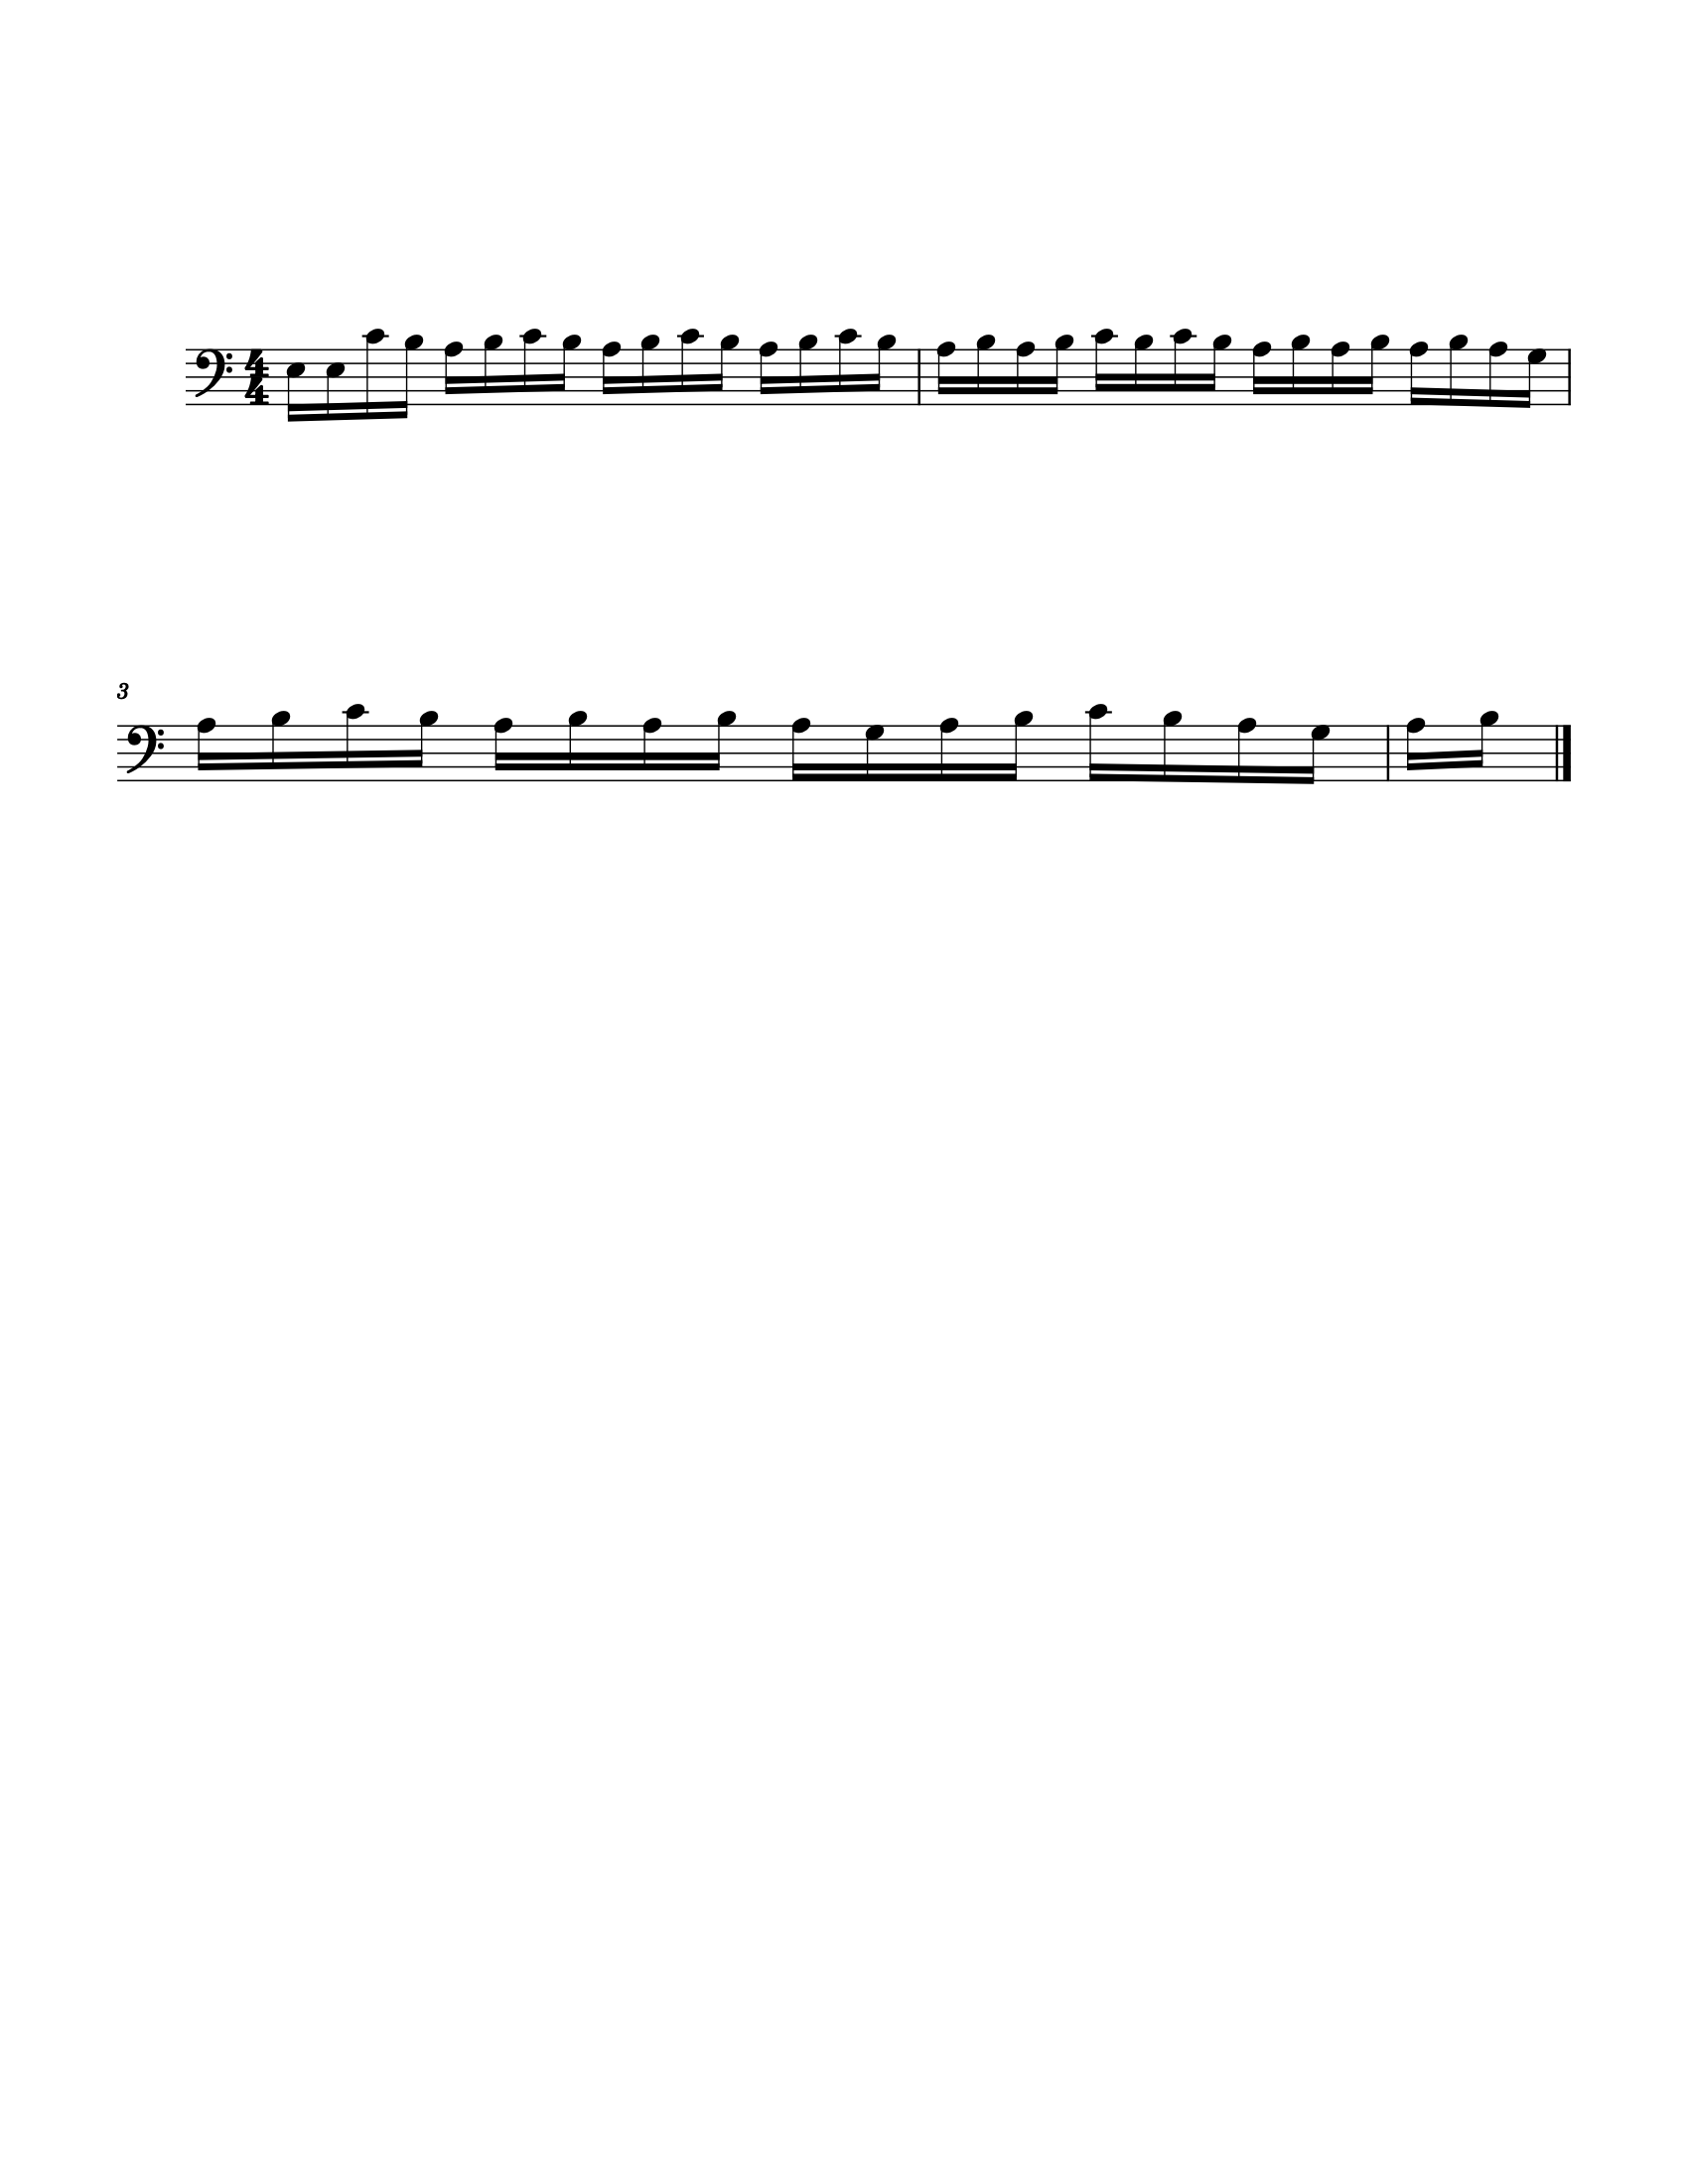

In [42]:
pred.show()

In [43]:
pred.play()